# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [109]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, min, max, split, udf, isnan, when, count, desc
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import plotly 
import matplotlib.pyplot as plt
import seaborn as sns

In [110]:
# create a Spark session
sparkify_session = SparkSession.builder \
    .appName("SparkifyProject") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [111]:
df = sparkify_session.read.json('mini_sparkify_event_data.json')

In [112]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [113]:
print('{} Rows, {} Columns'.format(df.count(), len(df.columns)))

286500 Rows, 18 Columns


In [114]:
# Selects the count of null values for each column and assigns column aliases
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

# Converts the result to a Pandas DataFrame
null_counts = null_counts.toPandas().transpose()

In [115]:
null_counts

,0
artist,58392
auth,0
firstName,8346
gender,8346
itemInSession,0
lastName,8346
length,58392
level,0
location,8346
method,0


In [116]:
df = df.dropna(how = "any", subset = ["userId", "sessionId"])

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### User Analysis 
1. Distribution of users by gender and level

2. Top users with the most activity

3. User activity patterns over time

In [117]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [118]:
df.createOrReplaceTempView("sparkify_data")

In [119]:
total_users = sparkify_session.sql('SELECT COUNT (DISTINCT userId) AS total_users FROM sparkify_data')
total_users.show()

+-----------+
|total_users|
+-----------+
|        226|
+-----------+



In [120]:
total_sessions = sparkify_session.sql('SELECT COUNT (DISTINCT sessionId) AS total_sessions FROM sparkify_data')
total_sessions.show()

+--------------+
|total_sessions|
+--------------+
|          2354|
+--------------+



In [121]:
# Distribution of users by gender
gender_distribution = sparkify_session.sql('SELECT gender, COUNT(DISTINCT userId) FROM sparkify_data GROUP BY gender')
gender_distribution.show()

+------+----------------------+
|gender|count(DISTINCT userId)|
+------+----------------------+
|     F|                   104|
|  null|                     1|
|     M|                   121|
+------+----------------------+



In [122]:
# Distribution of users by level
level_distribution = sparkify_session.sql('SELECT level, COUNT(userId) AS count FROM sparkify_data GROUP BY level')
level_distribution.show()

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+



In [123]:
# Top users with the most activity
top_users_activity = sparkify_session.sql('SELECT userId, COUNT(itemInSession) AS activity_count FROM sparkify_data GROUP BY userId ORDER BY activity_count DESC')
top_users_activity.show()

+------+--------------+
|userId|activity_count|
+------+--------------+
|    39|          9632|
|      |          8346|
|    92|          7230|
|   140|          6880|
|300011|          5732|
|   124|          4825|
|300021|          4659|
|300017|          4428|
|    85|          4370|
|    42|          4257|
|200023|          3769|
|     6|          3761|
|    29|          3603|
|    54|          3437|
|   100|          3214|
|     9|          3191|
|   126|          3102|
|300015|          3051|
|    91|          3014|
|    98|          2891|
+------+--------------+
only showing top 20 rows



In [124]:
# User activity patterns over time
average_session_length = sparkify_session.sql('SELECT userId, AVG(length) AS average_session_length FROM sparkify_data GROUP BY userId')
average_session_length.show()

+------+----------------------+
|userId|average_session_length|
+------+----------------------+
|    51|    247.88055082899103|
|   124|    248.17653659965674|
|     7|    253.56058066666665|
|    54|    250.38539934530093|
|    15|    249.37701452978044|
|   132|     250.5803443153526|
|   101|    249.00612947690564|
|    11|     246.7851051622875|
|   138|    247.56032983574872|
|    29|    249.18017257926041|
|    69|    254.27913390222233|
|    42|    246.79344140218302|
|   112|    246.80347251162786|
|    87|    252.46409273793992|
|    73|    249.97440710875327|
|     3|    254.32124037383176|
|    30|    253.92254455892746|
|   113|     252.4253198864354|
|    34|    243.98272735849056|
|    59|     249.2193277209945|
+------+----------------------+
only showing top 20 rows



### Artist and Song Analysis
1. Distribution of artists and songs in the dataset

2. Most popular artists or songs based on play count or user interactions

3. Relationship between song length and user engagement

In [125]:
# Distribution of artists and songs in the dataset
artist_distribution = sparkify_session.sql('SELECT artist, COUNT(artist) AS count FROM sparkify_data GROUP BY artist')
song_distribution = sparkify_session.sql('SELECT song, COUNT(song) AS count FROM sparkify_data GROUP BY song')

artist_distribution.show()
song_distribution.show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|      The Black Keys| 1125|
|         Silverstein|   60|
|           Kate Nash|   99|
|        Yann Tiersen|  139|
|    Jane's Addiction|   68|
|          Tim Hughes|   39|
|          Carl Craig|    3|
|Dashboard Confess...|   98|
|Yonder Mountain S...|   63|
|           Los Lobos|   45|
|Pete Rock & C.L. ...|    2|
|        Ziggy Marley|   28|
|      Jarabe De Palo|   83|
|               Rufio|   13|
|WC And The Maad C...|    1|
|      Jorge Gonzalez|   24|
|                Silk|   22|
|  The Watts Prophets|    6|
|            La Shica|    2|
|        Generation X|   19|
+--------------------+-----+
only showing top 20 rows

+--------------------+-----+
|                song|count|
+--------------------+-----+
|Never Gonna Be Al...|   50|
|         TULENLIEKKI|   16|
|      Underwaterboys|    1|
|Saor (Free)/News ...|    1|
|               New E|    1|
|The Geeks Were Right|    2|
|              He

In [126]:
# Most popular artists or songs based on play count or user interactions
popular_artists = sparkify_session.sql('SELECT artist, COUNT(artist) AS play_count FROM sparkify_data WHERE page = "NextSong" GROUP BY artist ORDER BY play_count DESC')
popular_songs = sparkify_session.sql('SELECT song, COUNT(song) AS play_count FROM sparkify_data WHERE page = "NextSong" GROUP BY song ORDER BY play_count DESC')

popular_artists.show()
popular_songs.show()

+--------------------+----------+
|              artist|play_count|
+--------------------+----------+
|       Kings Of Leon|      1841|
|            Coldplay|      1813|
|Florence + The Ma...|      1236|
|       Dwight Yoakam|      1135|
|            BjÃÂ¶rk|      1133|
|      The Black Keys|      1125|
|                Muse|      1090|
|       Justin Bieber|      1044|
|        Jack Johnson|      1007|
|              Eminem|       953|
|           Radiohead|       884|
|     Alliance Ethnik|       876|
|               Train|       854|
|        Taylor Swift|       840|
|         OneRepublic|       828|
|         The Killers|       822|
|         Linkin Park|       787|
|         Evanescence|       781|
|            Harmonia|       729|
|           Daft Punk|       713|
+--------------------+----------+
only showing top 20 rows

+--------------------+----------+
|                song|play_count|
+--------------------+----------+
|      You're The One|      1153|
|                Undo|

In [127]:
# Relationship between song length and user engagement
song_length_user_engagement = sparkify_session.sql('SELECT song, SUM(length) AS total_length, COUNT(DISTINCT userId) AS user_count, AVG(length) AS avg_length FROM sparkify_data GROUP BY song')

song_length_user_engagement.show()

+--------------------+------------------+----------+------------------+
|                song|      total_length|user_count|        avg_length|
+--------------------+------------------+----------+------------------+
|You Ain't Seen No...|        2730.65208|        12|210.05015999999998|
|  Yo Queria Ser Fiel|         304.56118|         1|         304.56118|
|             Amazing|        2015.73383|        11|         183.24853|
|I've Just Seen A ...|         1104.9751|         9|         110.49751|
|    Sic Of Elephants|2866.6730000000002|         9|          286.6673|
|      Billy Breathes|        2984.61636|         8|         331.62404|
|          Nada De Ti|2883.9133999999995|        11| 262.1739454545454|
|             Push It| 6892.602629999999|        29|215.39383218749998|
|              Heaven|       20606.75938|        58| 239.6134811627907|
|      Underwaterboys|         290.84689|         1|         290.84689|
|               Virgo|         206.91546|         1|         206

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Kings Of Leon'),
  Text(1, 0, 'Coldplay'),
  Text(2, 0, 'Florence + The Machine'),
  Text(3, 0, 'Dwight Yoakam'),
  Text(4, 0, 'BjÃ\x83Â¶rk'),
  Text(5, 0, 'The Black Keys'),
  Text(6, 0, 'Muse'),
  Text(7, 0, 'Justin Bieber'),
  Text(8, 0, 'Jack Johnson'),
  Text(9, 0, 'Eminem')])

/Users/fuchunyang/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 131 (\x83) missing from current font.
  func(*args, **kwargs)
/Users/fuchunyang/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 131 (\x83) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


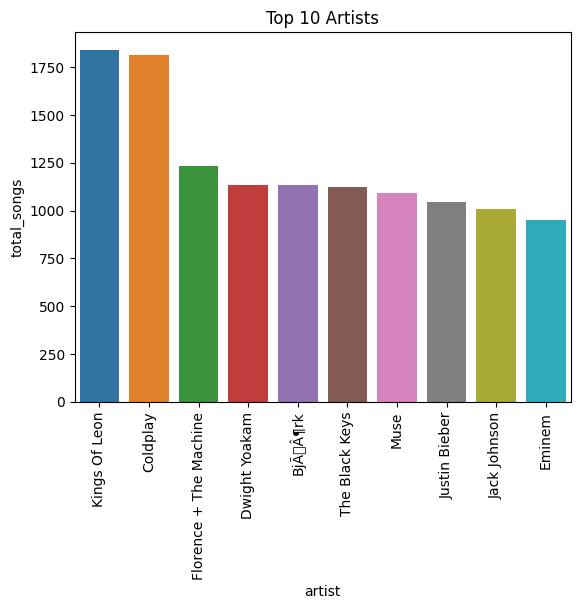

In [128]:
artists = sparkify_session.sql('Select artist, count(artist) as total_songs from sparkify_data \
group by artist \
order by total_songs desc \
limit 10').toPandas()

sns.barplot(x='artist', y='total_songs', data= artists)
plt.title('Top 10 Artists')
plt.xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, "You're The One"),
  Text(1, 0, 'Undo'),
  Text(2, 0, 'Revelry'),
  Text(3, 0, 'Sehr kosmisch'),
  Text(4, 0, 'Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)'),
  Text(5, 0, 'Dog Days Are Over (Radio Edit)'),
  Text(6, 0, 'Secrets'),
  Text(7, 0, 'Use Somebody'),
  Text(8, 0, 'Canada'),
  Text(9, 0, 'Invalid')])

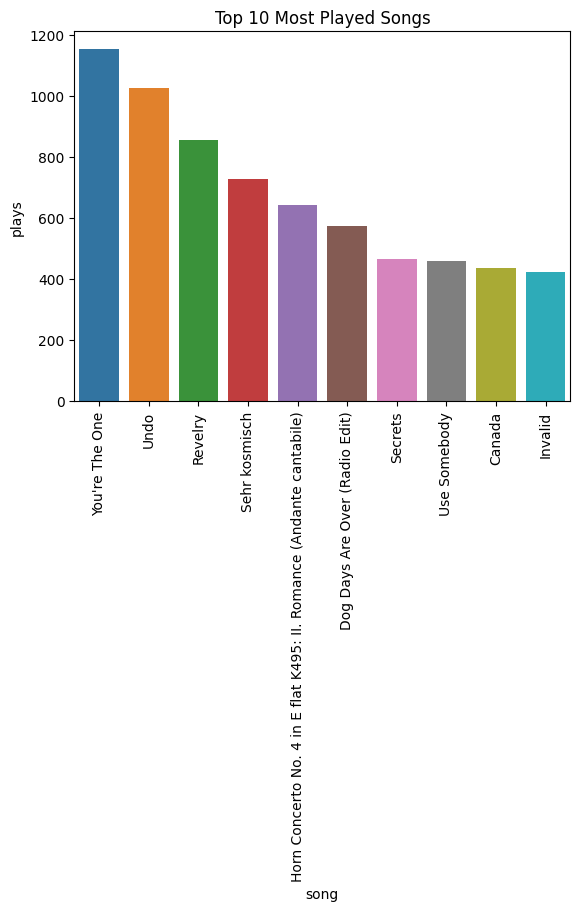

In [129]:
# What are the most played songs?
songs = sparkify_session.sql('select song, count(song) as plays from sparkify_data \
group by song \
order by plays desc \
limit 10').toPandas()

sns.barplot(x='song', y='plays', data= songs)
plt.title('Top 10 Most Played Songs')
plt.xticks(rotation = 90)

### Page Analysis
1. Explore the different types of user interactions captured in the page column, such as playing a song, adding to a playlist, or subscribing.
2. Analyze the frequency and patterns of different page events.
3. Investigate the sequence of page events to understand user behavior or the flow of user sessions

In [130]:
# Explore different types of user interactions captured in the page column
user_interactions = sparkify_session.sql('SELECT page, COUNT(userId) AS count FROM sparkify_data GROUP BY page')

user_interactions.show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 14457|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   924|
|            Settings|  1514|
|               Login|  3241|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1726|
|             Upgrade|   499|
|               Error|   258|
|      Submit Upgrade|   159|
+--------------------+------+
only showing top 20 rows



In [131]:
# Analyze the frequency and patterns of different page events
page_event_frequency = sparkify_session.sql('SELECT page, COUNT(userId) AS frequency FROM sparkify_data GROUP BY page')

page_event_frequency.show()

+--------------------+---------+
|                page|frequency|
+--------------------+---------+
|              Cancel|       52|
|    Submit Downgrade|       63|
|         Thumbs Down|     2546|
|                Home|    14457|
|           Downgrade|     2055|
|         Roll Advert|     3933|
|              Logout|     3226|
|       Save Settings|      310|
|Cancellation Conf...|       52|
|               About|      924|
|            Settings|     1514|
|               Login|     3241|
|     Add to Playlist|     6526|
|          Add Friend|     4277|
|            NextSong|   228108|
|           Thumbs Up|    12551|
|                Help|     1726|
|             Upgrade|      499|
|               Error|      258|
|      Submit Upgrade|      159|
+--------------------+---------+
only showing top 20 rows



In [132]:
# Investigate the sequence of page events to understand user behavior or the flow of user sessions
user_page_sequence = sparkify_session.sql('SELECT userId, collect_list(page) AS page_sequence FROM sparkify_data GROUP BY userId')

user_page_sequence.show()

+------+--------------------+
|userId|       page_sequence|
+------+--------------------+
|      |[Home, Login, Hom...|
|    10|[NextSong, NextSo...|
|   100|[Home, NextSong, ...|
|100001|[Home, NextSong, ...|
|100002|[Home, NextSong, ...|
|100003|[NextSong, NextSo...|
|100004|[Home, NextSong, ...|
|100005|[Home, NextSong, ...|
|100006|[Home, NextSong, ...|
|100007|[NextSong, Add to...|
|100008|[NextSong, NextSo...|
|100009|[NextSong, NextSo...|
|100010|[NextSong, NextSo...|
|100011|[Home, NextSong, ...|
|100012|[NextSong, NextSo...|
|100013|[NextSong, NextSo...|
|100014|[NextSong, NextSo...|
|100015|[NextSong, NextSo...|
|100016|[NextSong, NextSo...|
|100017|[NextSong, NextSo...|
+------+--------------------+
only showing top 20 rows



### Location Analysis
1. Analyze the distribution of users by location (location column) to identify regions with the highest user activity.
2. Investigate if user behavior or preferences vary across different locations.

In [133]:
# Analyze the distribution of users by location
user_location_distribution = sparkify_session.sql('SELECT location, COUNT(userId) AS user_count FROM sparkify_data GROUP BY location')

user_location_distribution.show()

+--------------------+----------+
|            location|user_count|
+--------------------+----------+
|     Gainesville, FL|      1229|
|Atlantic City-Ham...|      2176|
|Deltona-Daytona B...|        73|
|Kingsport-Bristol...|      1863|
|New Haven-Milford...|      4007|
|         Dubuque, IA|       651|
|Las Vegas-Henders...|      2042|
|Indianapolis-Carm...|       970|
|Seattle-Tacoma-Be...|       246|
|   Winston-Salem, NC|       819|
|     Bakersfield, CA|      1775|
|Los Angeles-Long ...|     30131|
|Minneapolis-St. P...|      2134|
|San Francisco-Oak...|      2647|
|Phoenix-Mesa-Scot...|      4846|
|Allentown-Bethleh...|       815|
|Miami-Fort Lauder...|      3764|
|           Selma, AL|      2027|
|          Dayton, OH|       259|
|Bridgeport-Stamfo...|       893|
+--------------------+----------+
only showing top 20 rows



In [134]:
# Investigate if user behavior or preferences vary across different locations
user_behavior_by_location = sparkify_session.sql('SELECT location, page, COUNT(userId) AS user_count FROM sparkify_data GROUP BY location, page')

user_behavior_by_location.show()

+--------------------+---------------+----------+
|            location|           page|user_count|
+--------------------+---------------+----------+
|         Jackson, MS|Add to Playlist|        87|
|       Anchorage, AK|    Thumbs Down|        10|
|        Danville, VA| Submit Upgrade|         1|
|Buffalo-Cheektowa...|           Help|         3|
|           Selma, AL|        Upgrade|         2|
|           Price, UT|      Downgrade|         5|
|Austin-Round Rock...|       NextSong|      1412|
|          Dayton, OH|     Add Friend|         4|
|Chicago-Napervill...|       NextSong|      4088|
|New York-Newark-J...|          About|        51|
|        Billings, MT|      Thumbs Up|        84|
|Minneapolis-St. P...|           Help|         7|
|          Laurel, MS|         Logout|        11|
|Omaha-Council Blu...|Add to Playlist|         3|
|     Gainesville, FL|         Logout|        15|
|Milwaukee-Waukesh...|         Logout|        10|
|          Dayton, OH|          About|         2|


### Device or Browser Analysis
1. Extract information from the userAgent column to analyze the types of devices or browsers used by the users.
2. Explore user behavior or preferences based on the device or browser information.

In [135]:
# Extract information from the userAgent column to analyze the types of devices or browsers used by the users
user_agent_analysis = sparkify_session.sql('SELECT userId, userAgent FROM sparkify_data GROUP BY userId, userAgent')

user_agent_analysis.show()

+------+--------------------+
|userId|           userAgent|
+------+--------------------+
|     7|Mozilla/5.0 (Wind...|
|   117|"Mozilla/5.0 (Win...|
|   150|"Mozilla/5.0 (Mac...|
|    98|"Mozilla/5.0 (Mac...|
|    38|"Mozilla/5.0 (Mac...|
|    41|Mozilla/5.0 (comp...|
|    88|Mozilla/5.0 (Wind...|
|   110|"Mozilla/5.0 (Mac...|
|    27|"Mozilla/5.0 (Win...|
|   129|"Mozilla/5.0 (Win...|
|   121|Mozilla/5.0 (X11;...|
|    80|"Mozilla/5.0 (Mac...|
|   112|Mozilla/5.0 (Wind...|
|    33|Mozilla/5.0 (Maci...|
|    14|Mozilla/5.0 (Maci...|
|    67|"Mozilla/5.0 (Mac...|
|   111|"Mozilla/5.0 (Win...|
|   148|Mozilla/5.0 (Wind...|
|    92|"Mozilla/5.0 (iPa...|
|    30|Mozilla/5.0 (Wind...|
+------+--------------------+
only showing top 20 rows



In [136]:
# Explore user behavior or preferences based on the device or browser information
user_behavior_by_device_browser = sparkify_session.sql('SELECT userAgent, COUNT(userId) AS user_count FROM sparkify_data GROUP BY userAgent')

user_behavior_by_device_browser.show()

+--------------------+----------+
|           userAgent|user_count|
+--------------------+----------+
|"Mozilla/5.0 (Win...|      5238|
|Mozilla/5.0 (X11;...|        62|
|"Mozilla/5.0 (Mac...|     18448|
|Mozilla/5.0 (Wind...|      3214|
|Mozilla/5.0 (Wind...|      5989|
|Mozilla/5.0 (comp...|      8624|
|"Mozilla/5.0 (Win...|      7624|
|Mozilla/5.0 (Maci...|     10300|
|                null|      8346|
|"Mozilla/5.0 (iPh...|      1976|
|"Mozilla/5.0 (Win...|     15395|
|Mozilla/5.0 (Wind...|     16700|
|Mozilla/5.0 (comp...|       815|
|"Mozilla/5.0 (Mac...|       235|
|"Mozilla/5.0 (Mac...|       512|
|"Mozilla/5.0 (Win...|     14598|
|"Mozilla/5.0 (Win...|      2868|
|"Mozilla/5.0 (iPa...|      8912|
|Mozilla/5.0 (Wind...|      2442|
|"Mozilla/5.0 (Mac...|     17348|
+--------------------+----------+
only showing top 20 rows



### Churn Analysis
1. Define churn based on the Cancellation Confirmation event in the page column.
2. Analyze churn rates and identify potential factors that contribute to user churn.
3. Compare the behavior and engagement of users who churned versus those who stayed.

In [137]:
# Define churn based on the Cancellation Confirmation event in the page column
churned_users = sparkify_session.sql('SELECT DISTINCT userId FROM sparkify_data WHERE page = "Cancellation Confirmation"')
stayed_users = sparkify_session.sql('SELECT DISTINCT userId FROM sparkify_data').subtract(churned_users)

In [138]:
# Analyze churn rates
churn_rate = churned_users.count() / stayed_users.count()

print("Churn Rate: {:.2%}".format(churn_rate))

# Compare the behavior and engagement of users who churned versus those who stayed
churned_users_behavior = sparkify_session.sql('SELECT page, COUNT(userId) AS churned_count FROM sparkify_data WHERE userId IN (SELECT DISTINCT userId FROM sparkify_data WHERE page = "Cancellation Confirmation") GROUP BY page')

stayed_users_behavior = sparkify_session.sql('SELECT page, COUNT(userId) AS stayed_count FROM sparkify_data WHERE userId IN (SELECT DISTINCT userId FROM sparkify_data) AND page != "Cancellation Confirmation" GROUP BY page')

churned_users_behavior.show()
stayed_users_behavior.show()

Churn Rate: 29.89%
+--------------------+-------------+
|                page|churned_count|
+--------------------+-------------+
|              Cancel|           52|
|    Submit Downgrade|            9|
|         Thumbs Down|          496|
|                Home|         1672|
|           Downgrade|          337|
|         Roll Advert|          967|
|              Logout|          553|
|       Save Settings|           58|
|Cancellation Conf...|           52|
|               About|           56|
|            Settings|          270|
|     Add to Playlist|         1038|
|          Add Friend|          636|
|            NextSong|        36394|
|           Thumbs Up|         1859|
|                Help|          239|
|             Upgrade|          112|
|               Error|           32|
|      Submit Upgrade|           32|
+--------------------+-------------+

+-------------------+------------+
|               page|stayed_count|
+-------------------+------------+
|             Cancel|   

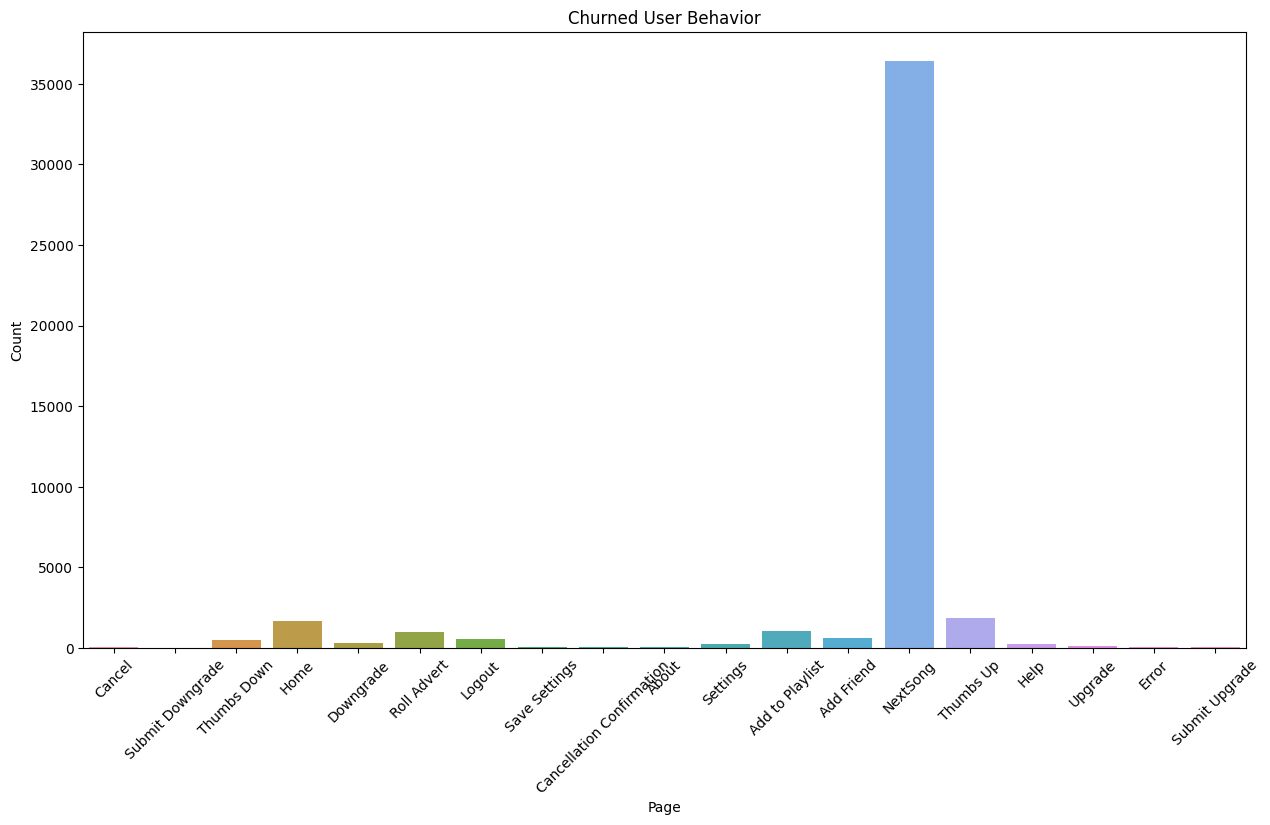

In [139]:
churned_users_behavior_df = churned_users_behavior.toPandas()
plt.figure(figsize=(15, 8))
sns.barplot(x='page', y='churned_count', data=churned_users_behavior_df)
plt.title('Churned User Behavior')
plt.xlabel('Page')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

# Display the plot
plt.show()

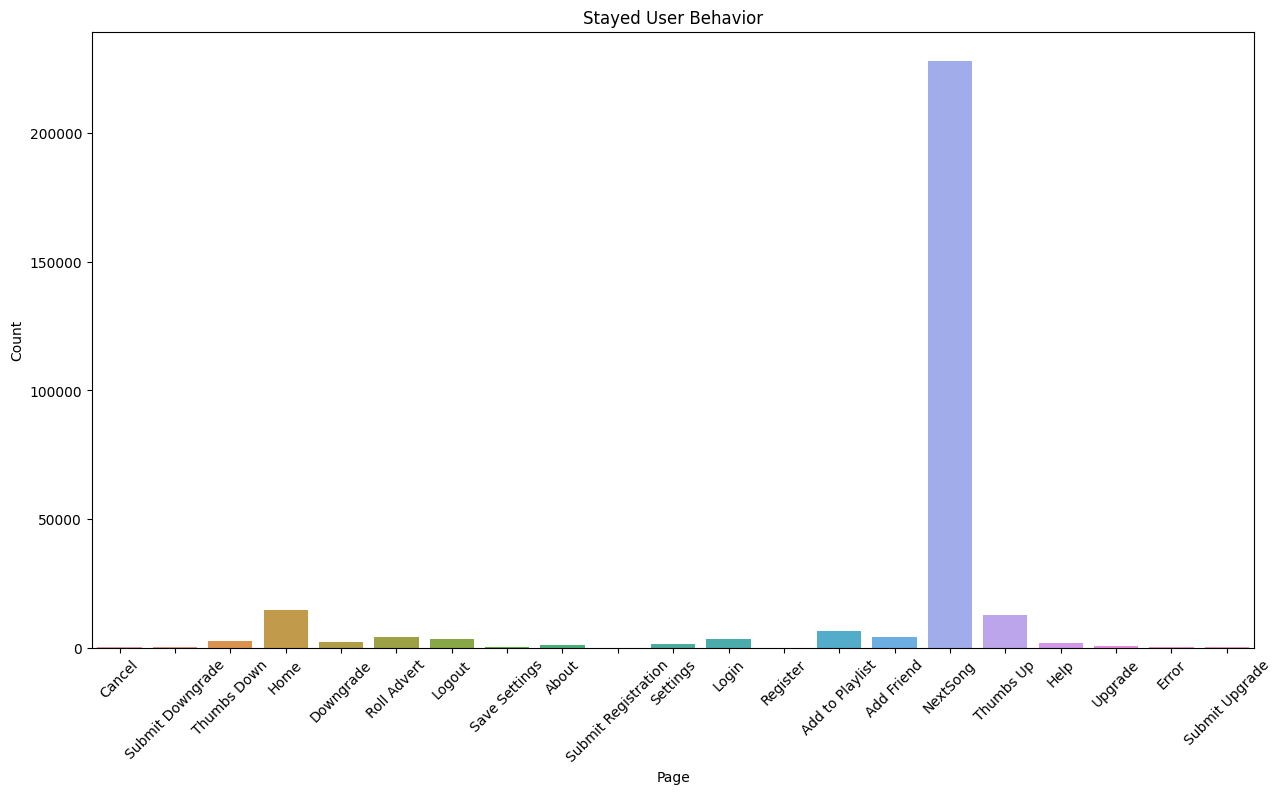

In [140]:
stayed_users_behavior_df = stayed_users_behavior.toPandas()
# Plot the stayed user behavior
plt.figure(figsize=(15, 8))
sns.barplot(x='page', y='stayed_count', data=stayed_users_behavior_df)
plt.title('Stayed User Behavior')
plt.xlabel('Page')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

# Display the plot
plt.show()

In [141]:
# Define churn flag UDF
churn_flag = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# Add isChurn column to DataFrame
df = df.withColumn('isChurn', churn_flag('page'))

# Define window specification for churn calculation
windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)

# Calculate churn count using window function
df = df.withColumn('churnCount', Fsum('isChurn').over(windowval))

# Create temporary view for data manipulation and exploration using SQL
df.createOrReplaceTempView('sparkify_churn_data')

# Total churned users
churn_distribution = sparkify_session.sql('SELECT churnCount AS isChurn, COUNT(DISTINCT userId) AS totalUsers FROM sparkify_churn_data GROUP BY churnCount').toPandas()

# Display churn distribution
print(churn_distribution)

   isChurn  totalUsers
0        0         174
1        1          52


Text(0.5, 1.0, 'Churned Customer Distribution')

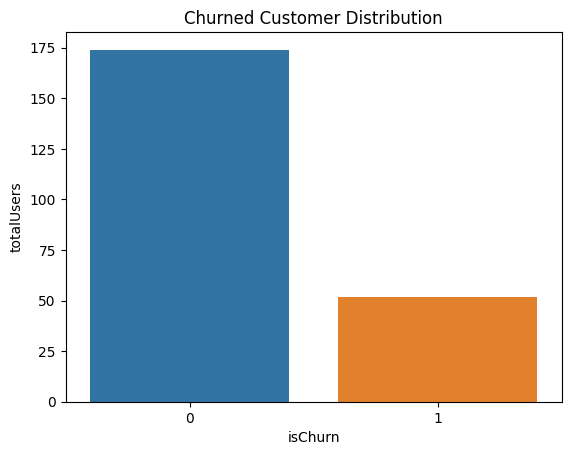

In [142]:
sns.barplot(x='isChurn', y='totalUsers', data= churn_distribution)
plt.title('Churned Customer Distribution')

Text(0.5, 1.0, 'Churned Customer Distribution by Gender')

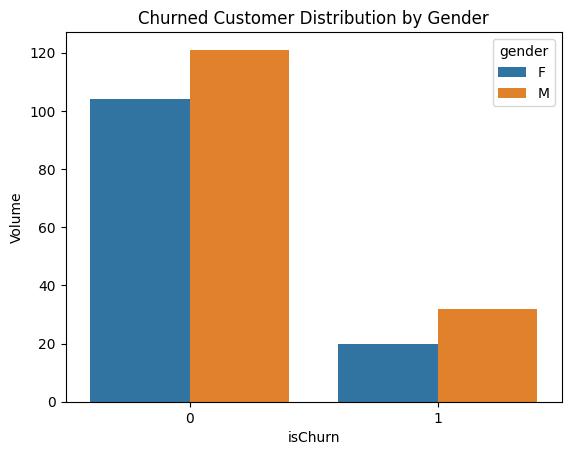

In [143]:
# Gender Distribution by Churn
gender_dist = sparkify_session.sql('Select isChurn, gender, count( distinct userId) from sparkify_churn_data \
group by isChurn, gender').withColumnRenamed('count(DISTINCT userId)', 'Volume').toPandas()
sns.barplot(x='isChurn', y='Volume', hue = 'gender', data= gender_dist)
plt.title('Churned Customer Distribution by Gender')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [144]:
def create_page_features(df):
    
    """ Creates features based on several of the values from the page variable
    Args:
    df (pyspark.sql.DataFrame): Spark DataFrame containing user activity data.

    Returns:
    list: List of Spark DataFrames, each representing a feature based on the counts of specific page values.
    """
    
    pages = ['Next Song', 'Add Friend', 'Thumbs Up', 'Thumbs Down', 'Add to Playlist']
    renamed_columns = ['skippedSongs', 'friendsAdded', 'thumbsUp', 'thumbsDown', 'playlistAdditions']
    page_features = []
    
    # Iterate over the pages and renamed columns to create features
    for page, renamed_col in zip(pages , renamed_columns):
        var = df.select('userId', 'page')\
        .groupby('userId', 'page')\
        .agg({'page' : 'count'})\
        .filter(df.page == page)\
        .withColumnRenamed('count(page)', renamed_col)
        # Append the created feature DataFrame to the list
        page_features.append(var)
        
    return page_features

In [146]:
def create_features(df):

    """ Creates all features for modelling and returns a new dataframe with each unique user as an instance
    Args:
    df (pyspark.sql.DataFrame): Spark DataFrame containing raw data.

    Returns:
    engineered_df (pyspark.sql.DataFrame): Spark DataFrame with unique users and their engineered features showcasing user behavior.
    """
    
    # Create gender feature
    male_flag = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
    df = df.withColumn('isMale', male_flag('gender'))
    
    # Create page features
    features = create_page_features(df)
    
    # Count total sessions
    sessions = df.select('userId', 'sessionId').\
    groupBy('userId').\
    agg({'sessionId': 'count'}).\
    withColumnRenamed('count(sessionId)', 'totalSessions')
    
    # Sum total Length
    total_length = df.select('userId', 'length').\
    groupBy('userId').\
    agg({'length': 'sum'}).\
    withColumnRenamed('sum(length)', 'totalLength')
    
    # Combine all features 
    features.extend([sessions, total_length])
    
    for i in features:
        df = df.join(i, on = ['userId'], how = 'outer')
    
    engineered_df = df.select('userId', 'isChurn', 'isMale', 'thumbsUp', 'thumbsDown', 'playlistAdditions', 
          'totalSessions', 'totalLength', 'friendsAdded', 'skippedSongs').dropDuplicates()

    return engineered_df

In [147]:
new_df = create_features(df)
new_df = new_df.fillna(0)

In [148]:
for i in ['thumbsUp', 'thumbsDown', 'playlistAdditions', 'totalSessions', 'totalLength', 'friendsAdded', 'skippedSongs']:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    new_df = pipeline.fit(new_df).transform(new_df).drop(i+"_Vect")

In [149]:
all_feat_assembler = VectorAssembler(inputCols=['thumbsUp_Scaled', 'thumbsDown_Scaled', 'playlistAdditions_Scaled', 
                                                'totalSessions_Scaled', 'totalLength_Scaled', 'friendsAdded_Scaled', 
                                                'skippedSongs_Scaled','isMale'],outputCol="features")
new_df = all_feat_assembler.transform(new_df)

In [150]:
new_df

DataFrame[userId: string, isChurn: int, isMale: int, thumbsUp: bigint, thumbsDown: bigint, playlistAdditions: bigint, totalSessions: bigint, totalLength: double, friendsAdded: bigint, skippedSongs: bigint, thumbsUp_Scaled: vector, thumbsDown_Scaled: vector, playlistAdditions_Scaled: vector, totalSessions_Scaled: vector, totalLength_Scaled: vector, friendsAdded_Scaled: vector, skippedSongs_Scaled: vector, features: vector]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [151]:
new_df = new_df.select(new_df['isChurn'].alias('label'),new_df['features'])

In [152]:
train, test = new_df.randomSplit([0.8, 0.2], seed = 42)
sub_test, validation = test.randomSplit([0.5, 0.5], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 236


Test Dataset Count: 42


In [154]:
rfc = RandomForestClassifier()
rfc_fitted_model = rfc.fit(train)
evaluator =  MulticlassClassificationEvaluator(metricName = 'f1')
predictions = rfc_fitted_model.transform(test)
f1_score = evaluator.evaluate(predictions)
print('Random Forest F1-Score: {}'.format(round(f1_score,2)))

Random Forest F1-Score: 0.69


In [160]:
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_fitted_model = lr.fit(train)
predictions = lr_fitted_model.transform(test)
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')
lr_f1_score = evaluator.evaluate(predictions)
print('Logistic Regression F1-Score: {}'.format(round(lr_f1_score,2)))

Logistic Regression F1-Score: 0.79


In [158]:
svm = LinearSVC(featuresCol="features", labelCol="label")
svm_fitted_model = svm.fit(train)
predictions = svm_fitted_model.transform(test)
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')
svm_f1_score = evaluator.evaluate(predictions)
print('SVM F1-Score: {}'.format(round(svm_f1_score,2)))

SVM F1-Score: 0.76


In [161]:
# Create a Random Forest classifier
rfc = RandomForestClassifier()

# Define the parameter grid to search over
paramGrid = ParamGridBuilder() \
    .addGrid(rfc.numTrees, [10, 50, 100]) \
    .addGrid(rfc.maxDepth, [5, 10, 20]) \
    .build()

# Create a cross-validator with the evaluation metric
evaluator = MulticlassClassificationEvaluator(metricName='f1')

# Create a cross-validator
crossval = CrossValidator(estimator=rfc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Fit the model with cross-validation
cvModel = crossval.fit(train)

# Get the best model
bestModel = cvModel.bestModel

# Make predictions on the test data using the best model
predictions = bestModel.transform(test)

# Evaluate the model
f1_score = evaluator.evaluate(predictions)
print('Random Forest F1-Score: {}'.format(round(f1_score, 2)))

23/07/03 15:44:24 WARN DAGScheduler: Broadcasting large task binary with size 1019.9 KiB
23/07/03 15:44:25 WARN DAGScheduler: Broadcasting large task binary with size 1001.4 KiB
23/07/03 15:44:41 WARN DAGScheduler: Broadcasting large task binary with size 1019.9 KiB
23/07/03 15:44:42 WARN DAGScheduler: Broadcasting large task binary with size 1001.4 KiB
23/07/03 15:49:06 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB
23/07/03 15:49:27 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB


Random Forest F1-Score: 0.71


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.